In [1]:
from fastai import *
from fastai.vision import *
import numpy as np
from fastai.widgets import *

In [3]:
file_dict = {'teddy':'teddy_bear.txt', 
             'grizzly':'grizzly_bear.txt', 
             'polar':'polar_bear.txt', 
             'black':'black_bear.txt'}

In [5]:
for folder, link in file_dict.items():
  path = Path('data/bears')
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(path/link, dest)

In [6]:
classes = ['teddy', 'grizzly', 'polar', 'black']

In [7]:
for c in classes:
  print(c)
  verify_images(path/c, delete=True)

teddy


grizzly


polar


black


In [39]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.3, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [40]:
data.classes

['black', 'grizzly', 'polar', 'teddy']

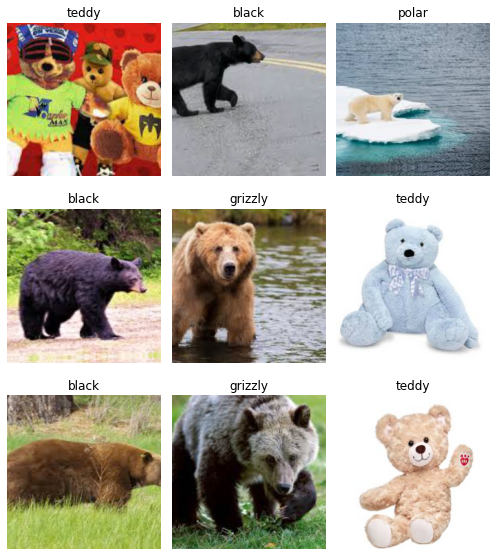

In [41]:
data.show_batch(rows=3, figsize=(7,8))

In [42]:
data.c, len(data.train_ds), len(data.valid_ds)

(4, 902, 386)

Train model

In [43]:
model = cnn_learner(data, models.resnet34, metrics=error_rate)

In [44]:
model.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.166256,0.216761,0.051813,00:10
1,0.639756,0.210786,0.054404,00:10
2,0.440925,0.201152,0.046632,00:10
3,0.323548,0.167799,0.044041,00:10
4,0.255599,0.163593,0.041451,00:10


In [45]:
model.save('stage-1')

In [46]:
model.unfreeze()

In [47]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


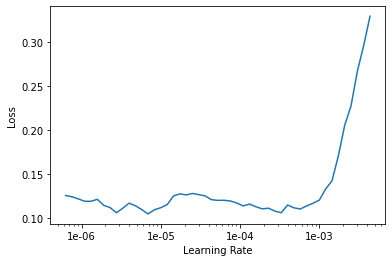

In [48]:
model.recorder.plot()

In [49]:
model.fit_one_cycle(3, max_lr=slice(3e-6, 3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.167757,0.270846,0.064767,00:11
1,0.195009,0.295303,0.072539,00:11
2,0.146552,0.303847,0.072539,00:11


Interpretation

In [50]:
model.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (902 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
grizzly,grizzly,grizzly,grizzly,grizzly
Path: data/bears;

Valid: LabelList (386 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
polar,polar,black,grizzly,grizzly
Path: data/bears;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [51]:
interp = ClassificationInterpretation.from_learner(model)

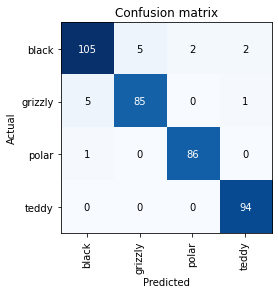

In [52]:
interp.plot_confusion_matrix()

Cleaning Up

In [58]:
db = (ImageList.from_folder(path).split_none().label_from_folder().transform(get_transforms(), size=224).databunch())

In [59]:
model_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
model_cln.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1288 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
grizzly,grizzly,grizzly,grizzly,grizzly
Path: data/bears;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/bears;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [60]:
ds, idx = DatasetFormatter().from_toplosses(model_cln)

In [61]:
ImageCleaner(ds, idx, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [62]:
ds, idx = DatasetFormatter().from_similars(model_cln)

Getting activations...


Computing similarities...


In [63]:
ImageCleaner(ds, idx, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Linear Regression Problem

In [2]:
n = 100

In [3]:
x = torch.ones(n, 2)
x[:, 0].uniform_(-1, 1)
x[:5]

tensor([[ 0.3071,  1.0000],
        [-0.3765,  1.0000],
        [-0.7275,  1.0000],
        [-0.4998,  1.0000],
        [ 0.5263,  1.0000]])

In [4]:
a = tensor(3., 2)
a

tensor([3., 2.])

In [5]:
y = x@a + torch.rand(n)

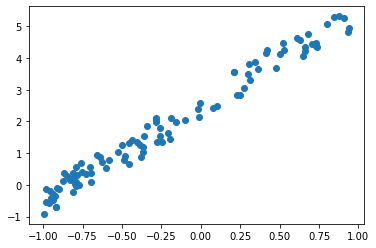

In [6]:
plt.scatter(x[:,0], y)

In [10]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()

In [13]:
a = tensor(-1., 1)

In [14]:
y_hat = x@a
mse(y_hat, y)

tensor(6.1362)

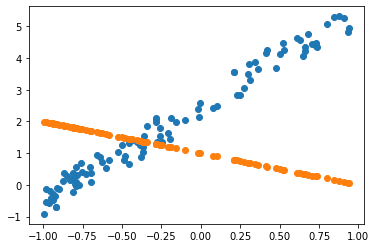

In [15]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], y_hat)

Gradient descent

In [16]:
a = nn.Parameter(a)
a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [17]:
def update():
  y_hat = x@a
  loss = mse(y, y_hat)
  if t%10 == 0: print(loss)
  loss.backward()
  with torch.no_grad():
    a.sub_(lr * a.grad)
    a.grad.zero_()

In [18]:
lr = 1e-1
for t in range(100): update()

tensor(6.1362, grad_fn=<MeanBackward0>)
tensor(1.5824, grad_fn=<MeanBackward0>)
tensor(0.4549, grad_fn=<MeanBackward0>)
tensor(0.1725, grad_fn=<MeanBackward0>)
tensor(0.1018, grad_fn=<MeanBackward0>)
tensor(0.0841, grad_fn=<MeanBackward0>)
tensor(0.0796, grad_fn=<MeanBackward0>)
tensor(0.0785, grad_fn=<MeanBackward0>)
tensor(0.0782, grad_fn=<MeanBackward0>)
tensor(0.0782, grad_fn=<MeanBackward0>)


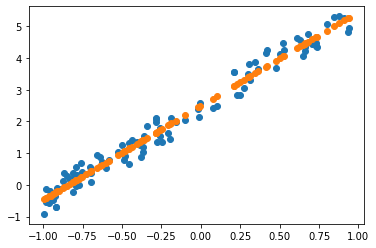

In [19]:
plt.scatter(x[:,0], y)
plt.scatter(x[:,0], x@a.detach())

Animation Time

In [20]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [24]:
a = nn.Parameter(tensor(-1., 1))

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], x@a.detach())
plt.close()

def animate(i):
  update()
  line.set_ydata(x@a.detach())
  return line,

In [25]:
animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)